I copied this data to my Workstation to the folder /home/semc/Aygul_DL/Deep-learning/kaggle and uploaded it here.

In [ ]:
Temporary_notebook_9_noAugmentation_noBatchnorm_withDropoutLayers_withEarlyStop_lr_0_001

In [1]:
import os

file_name = "/home/semc/Aygul_DL/Deep-learning/kaggle/archive_dataset2.zip"  # location and name of data file
file_size = os.path.getsize(file_name)

print(f'User uploaded file "{file_name}" with length {file_size} bytes')

User uploaded file "/home/semc/Aygul_DL/Deep-learning/kaggle/archive_dataset2.zip" with length 825979578 bytes


In [2]:
cd /home/semc/Aygul_DL/Deep-learning/kaggle

/home/semc/Aygul_DL/Deep-learning/kaggle


In [3]:
# Unzip the dataset (aldeary upzipped)
#!unzip archive_dataset2.zip

In [5]:
#ls

In [5]:
# Open the file for reading
with open("readme[1].txt", "r") as f:
    # Read the contents of the file
    contents = f.read()

# Print the contents of the file
print(contents)

For information see http://research.microsoft.com/en-us/projects/asirra/corpus.aspx

Contact: jelson



In [6]:
cd PetImages/

/home/semc/Aygul_DL/Deep-learning/kaggle/PetImages


In [7]:
ls

Cat/  Dog/


In [8]:
cd Cat/

/home/semc/Aygul_DL/Deep-learning/kaggle/PetImages/Cat


In [4]:
#ls

So, images are in jpg format. They are stored in 2 folders 'Cat' and 'Dog'.

In [11]:
# Beginnning of the large code chunk:

import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
from PIL import Image, UnidentifiedImageError
import os
import pytz
from datetime import datetime
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F


def print_debug(statement):
    tz_NY = pytz.timezone('America/New_York')
    datetime_NY = datetime.now(tz_NY)
    print(f"{datetime_NY.strftime('%Y-%m-%d %H:%M:%S')} - DEBUG: {statement}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

dataset_path = "/home/semc/Aygul_DL/Deep-learning/kaggle/PetImages"

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4883389174938202, 0.4552995264530182, 0.4170547127723694], std=[0.2597983777523041, 0.25312772393226624, 0.2558419108390808]
)
])


test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4883389174938202, 0.4552995264530182, 0.4170547127723694], std=[0.2597983777523041, 0.25312772393226624, 0.2558419108390808]
)
])


class RobustImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        try:
            return super(RobustImageFolder, self).__getitem__(index)
        except (IOError, UnidentifiedImageError) as e:
            print_debug(f"Error loading image; skipping index {index}. Error: {e}")
            return None

full_dataset = RobustImageFolder(root=dataset_path, transform=None)
full_dataset = [item for item in full_dataset if item is not None]

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
torch.manual_seed(0)  # Set a random seed for reproducibility
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])


class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset.dataset[self.dataset.indices[idx]]
        if self.transform:
            image = self.transform(image)
        return image, label

train_dataset = CustomImageDataset(train_dataset, transform=train_transform)
test_dataset = CustomImageDataset(test_dataset, transform=test_transform)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

Using device: cuda
2024-05-09 09:49:26 - DEBUG: Error loading image; skipping index 8790. Error: cannot identify image file <_io.BufferedReader name='/home/semc/Aygul_DL/Deep-learning/kaggle/PetImages/Cat/666.jpg'>
2024-05-09 09:49:30 - DEBUG: Error loading image; skipping index 14395. Error: cannot identify image file <_io.BufferedReader name='/home/semc/Aygul_DL/Deep-learning/kaggle/PetImages/Dog/11702.jpg'>


/usr/lib/python3/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [12]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 28 * 28, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x

# Test different learning rates:¶

2024-05-09 10:15:34 - DEBUG: Initial Train Loss: 0.6929448795394776, Initial Train Accuracy: 50.225022502250226%
2024-05-09 10:15:34 - DEBUG: Initial Validation Loss: 0.6927942776981788, Initial Validation Accuracy: 49.56%
2024-05-09 10:15:56 - DEBUG: Epoch 1, Train Loss: 0.6775, Train Accuracy: 57.41%.
2024-05-09 10:15:59 - DEBUG: Validation Loss: 0.6184, Validation Accuracy: 63.58%.
2024-05-09 10:15:59 - DEBUG: Model improved and saved at epoch 1 into the file model6_with_augmentation_noBatchnorm_lr0_001.pth.
2024-05-09 10:16:20 - DEBUG: Epoch 2, Train Loss: 0.6335, Train Accuracy: 63.93%.
2024-05-09 10:16:23 - DEBUG: Validation Loss: 0.5775, Validation Accuracy: 69.36%.
2024-05-09 10:16:24 - DEBUG: Model improved and saved at epoch 2 into the file model6_with_augmentation_noBatchnorm_lr0_001.pth.
2024-05-09 10:16:45 - DEBUG: Epoch 3, Train Loss: 0.5936, Train Accuracy: 68.52%.
2024-05-09 10:16:48 - DEBUG: Validation Loss: 0.5523, Validation Accuracy: 70.92%.
2024-05-09 10:16:48 - DE

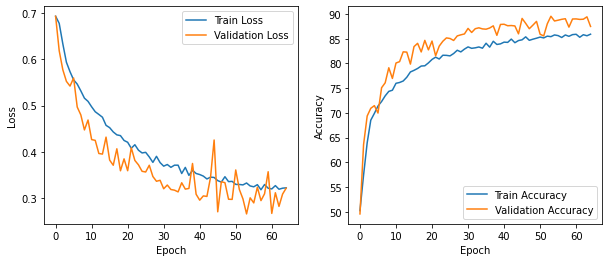

In [15]:
model = MyModel()
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            outputs = outputs.squeeze(1)
            labels = labels.float()  # Ensure labels are float for BCELoss
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            predicted = torch.round(outputs)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    average_loss = total_loss / len(data_loader)
    accuracy = 100 * correct / total
    return average_loss, accuracy

# Evaluate the model initially
initial_train_loss, initial_train_accuracy = evaluate_model(model, train_loader, criterion, device)
initial_val_loss, initial_val_accuracy = evaluate_model(model, test_loader, criterion, device)

print_debug(f'Initial Train Loss: {initial_train_loss}, Initial Train Accuracy: {initial_train_accuracy}%')
print_debug(f'Initial Validation Loss: {initial_val_loss}, Initial Validation Accuracy: {initial_val_accuracy}%')

# Initialize lists for plotting
train_losses = [initial_train_loss]
val_losses = [initial_val_loss]
train_accuracies = [initial_train_accuracy]
val_accuracies = [initial_val_accuracy]

num_epochs = 150
best_val_loss = float('inf')
last_improvement = 0
patience = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        if inputs is None:
            continue
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.float()
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.squeeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print_debug(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%.")

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            if inputs is None:
                continue
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float()
            outputs = model(inputs)
            outputs = outputs.squeeze(1)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            predicted = (outputs > 0.5).float()
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(test_loader)
    val_accuracy = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print_debug(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%.")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        last_improvement = epoch
        torch.save(model.state_dict(), '/home/semc/Aygul_DL/Deep-learning/kaggle/model6_with_augmentation_noBatchnorm_lr0_001.pth')
        print_debug(f"Model improved and saved at epoch {epoch+1} into the file model6_with_augmentation_noBatchnorm_lr0_001.pth.")

    if epoch - last_improvement > patience:
        print_debug("No improvement in validation loss for several epochs, stopping training.")
        break

# Calculate the actual number of epochs data was collected
actual_num_epochs = len(train_losses)  # Assuming train_losses and val_losses are updated every epoch

plt.figure(figsize=(10, 4))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(actual_num_epochs), train_losses, label='Train Loss')
plt.plot(range(actual_num_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epoch', color='black')
plt.ylabel('Loss', color='black')
plt.tick_params(axis='both', colors='black')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(actual_num_epochs), train_accuracies, label='Train Accuracy')
plt.plot(range(actual_num_epochs), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch', color='black')
plt.ylabel('Accuracy', color='black')
plt.tick_params(axis='both', colors='black')
plt.legend()

plt.show()